# Model organic aerosol ratios

## Goal: Calculate the ratio oa / (oa + so4 + bc) for both CESM2 and NorESM

### Plot and save the ratios for both models using an Arctic Projection. 

Check for a significant trend in the relative bias of this value between the values. Sample at the Arctic observatories used previously

In [1]:
from imports import (
        pd, np, xr, mpl, plt, sns, os,
        glob, datetime, sys, crt, LogNorm
    )

from functions import select_from_netcdf, just_values
#import cartopy.crs as ccrs
ccrs = crt.crs

#from functions import 
base_dir = '/home/notebook/basics/saved_data/'
start_date = '2000-01-01'; end_date = '2010-01-01' # Set start and end dates

/opt/conda/lib/python3.7/site-packages/geonum/__init__.py:39: UserWarning: Plotting of maps etc. is deactivated, please install Basemap
  warn('Plotting of maps etc. is deactivated, please install Basemap')


In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


1. Calculate monthly averages for the three aerosol constituents in CESM2 for the time period 2000-2010. Observations were made 2006-09

collect file paths for CESM2-WACCM:

In [3]:
mmroa_path = '~/shared-cmip6-for-ns1000k/historical/CESM2-WACCM/r1i1p1f1/mmroa_AERmon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc'
mmrso4_path = '~/shared-cmip6-for-ns1000k/historical/CESM2-WACCM/r1i1p1f1/mmrso4_AERmon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc'
mmrbc_path = '~/shared-cmip6-for-ns1000k/historical/CESM2-WACCM/r1i1p1f1/mmrbc_AERmon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc'

# Potentially to use later :
mmrnh4_path = '~/shared-cmip6-for-ns1000k/historical/CESM2-WACCM/r1i1p1f1/mmrnh4_AERmon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc'
mmrdust_path = '~/shared-cmip6-for-ns1000k/historical/CESM2-WACCM/r1i1p1f1/mmrdust_AERmon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc'

Dictionary to reference data objects:

In [4]:
data_paths = {'mmroa':mmroa_path,
              'mmrso4':mmrso4_path,
              'mmrbc':mmrbc_path}

Save data for each variable for the lowest level of the atmosphere, and for the appropriate time step within 'data_paths'

In [24]:
cesm_all = xr.Dataset()
date_range = (start_date, end_date)
print('Processing...')
for i in data_paths: # for each GCM variable of interest
    print(i)
    _ma = select_from_netcdf(data_paths[i], var = i, lev_ind = 69, date_range = date_range, time_avg = 'time.month')
    cesm_all[i] = _ma

Processing...
mmroa


/opt/conda/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'mmroa' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


mmrso4


/opt/conda/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'mmrso4' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


mmrbc


/opt/conda/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'mmrbc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


Sum aerosol contributions from oa, so4, and bc. Calculate the ratio of interest.

In [25]:
cesm_all_aero = 0;
for source in cesm_all:
    if source in data_paths.keys():
        _aero = cesm_all[source] # Select July, equivalent to data_paths['mmroa'][1][6,:,:]
        cesm_all_aero += _aero

cesm2_ratio = cesm_all['mmroa'] / cesm_all_aero
cesm2_ratio_july = cesm2_ratio.isel(month = 6)

Label the new xarray object appropriately and add it the Dataset object

In [26]:
cesm2_ratio.name = 'cesm_aero_ratio'
cesm_all['aero_ratio'] = cesm2_ratio
cesm_all.to_netcdf(path = '~/basics/saved_data/aerosol_props_cesm2_2000_2010.nc')

In [27]:
cesm_all.data_vars

Data variables:
    mmroa       (month, lat, lon) float32 3.4187638e-13 ... 1.2583576e-11
    mmrso4      (month, lat, lon) float32 8.109986e-11 ... 3.3735226e-11
    mmrbc       (month, lat, lon) float32 5.2296004e-14 ... 4.788219e-12
    aero_ratio  (month, lat, lon) float32 0.004195109 0.004195113 ... 0.2462201

Initial plot shows organic aerosol as a larger fraction at Northern latitudes. Interesting, perhaps there are less anthropogenic emissions there?

Text(0.5,1,'CESM2-WACCM')

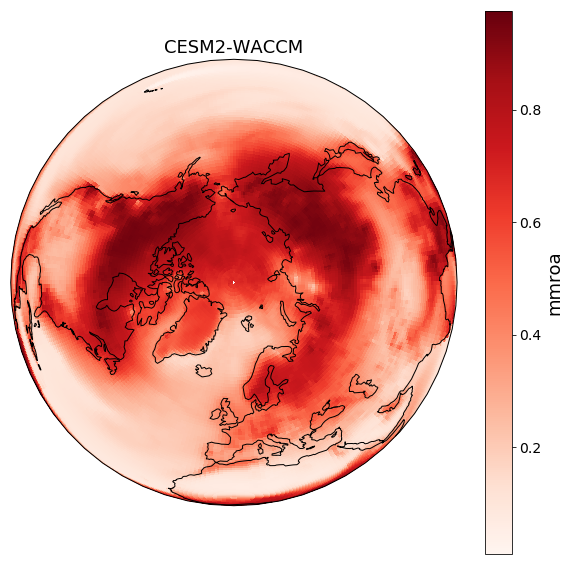

In [8]:
fig = plt.figure(1, figsize=[10,10])

# We're using cartopy and are plotting in Orthographic projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines()

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here PlateCarree)
cesm2_ratio_july.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds')

# One way to customize your title
plt.title('CESM2-WACCM', fontsize=18)

In [9]:
filename = "cesm2_aero_ratio_polar_2000_2010"
plt.savefig(base_dir + filename,format = 'png', dpi = 400)
plt.clf()

<Figure size 432x288 with 0 Axes>

## Repeat all previous steps with NorESM data

In [10]:
mmroa_path1 = '~/shared-cmip6-for-ns1000k/historical/NorESM2-LM/r1i1p1f1/mmroa_AERmon_NorESM2-LM_historical_r1i1p1f1_gn_200001-200912.nc'
mmrso4_path1 = '~/shared-cmip6-for-ns1000k/historical/NorESM2-LM/r1i1p1f1/mmrso4_AERmon_NorESM2-LM_historical_r1i1p1f1_gn_200001-200912.nc'
mmrbc_path1 = '~/shared-cmip6-for-ns1000k/historical/NorESM2-LM/r1i1p1f1/mmrbc_AERmon_NorESM2-LM_historical_r1i1p1f1_gn_200001-200912.nc'
mmrss_path1 = '~/shared-cmip6-for-ns1000k/historical/NorESM2-LM/r1i1p1f1/mmrss_AERmon_NorESM2-LM_historical_r1i1p1f1_gn_200001-200912.nc'

In [11]:
data_paths2 = {'mmroa':mmroa_path1,
              'mmrso4':mmrso4_path1,
              'mmrbc':mmrbc_path1}

Collect file paths for NorESM2-LM:

In [12]:
noresm_all = xr.Dataset()
vals = data_paths2.keys()
print('Processing...')
for i in data_paths2: # for each GCM variable of interest
    _ma = select_from_netcdf(data_paths2[i], var = i, lev_ind = 0, date_range = date_range, time_avg = 'time.month')
    print(i)
    noresm_all[i] = _ma

Processing...
mmroa
mmrso4
mmrbc


In [13]:
noresm_all_aero = 0;
for source in noresm_all:
    if source in data_paths2.keys():
        _aero = noresm_all[source]
        noresm_all_aero += _aero

noresm_ratio = noresm_all['mmroa'] / noresm_all_aero
noresm_ratio_july = noresm_ratio.isel(month = 6)

Label the new xarray object appropriately and add it the Dataset object

In [14]:
noresm_ratio.name = 'aero_ratio'
noresm_all['aero_ratio'] = noresm_ratio
noresm_all.to_netcdf(path = '~/basics/saved_data/aerosol_props_noresm_2000_2010.nc')

Text(0.5,1,'NorESM-ML')

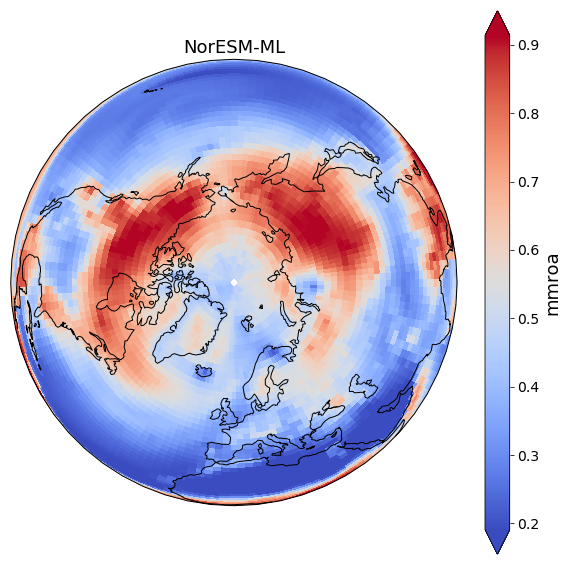

In [15]:
fig2 = plt.figure(2, figsize=[10,10])

# We're using cartopy and are plotting in Orthographic projection 
# (see documentation on cartopy)
ax2 = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax2.coastlines()

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here PlateCarree)
noresm_ratio_july.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='coolwarm', robust=True)

# One way to customize your title
plt.title('NorESM-ML', fontsize=18)

In [19]:
filename = "noresm_aero_ratio_polar_2000_2010.png"
plt.savefig(base_dir + filename,format = 'png', dpi = 400)
plt.clf()

<Figure size 432x288 with 0 Axes>

## Use a single observation at the Zeppelin observatory to make a small comparison

Could be expanded upon to automatically include more observatories

Location for the Zeppelin Observatory

In [20]:
obs_dict = {'Zeppelin': [78.907206, 11.885593]}

Select the Organic Aerosol values at Zeppelin and convert to ug/m3. Unit conversion procedure is flimsy.

In [36]:
temp_coords = obs_dict['Zeppelin'] # Get the coordinates
oa_zepp_july_noresm_mmr = noresm_july_oa.sel(lat=temp_coords[0], lon=temp_coords[1], method='nearest')
oa_zepp_july_cesm_mmr = cesm_july_oa.sel(lat=temp_coords[0], lon=temp_coords[1], method='nearest')
oa_zepp_july_noresm_density = oa_zepp_july_noresm_mmr * 1.25 * 1e9
oa_zepp_july_cesm_density = oa_zepp_july_cesm_mmr * 1.25 * 1e9
print('NorESM:', just_values(oa_zepp_july_noresm_density, 3), 'CESM: ', just_values(oa_zepp_july_cesm_density, 3))

NorESM: 0.181 CESM:  0.032


In [35]:
just_values(oa_zepp_july_noresm_density, 3)

0.181

In [37]:
temp_coords = obs_dict['Zeppelin'] # Get the coordinates
oa_zepp_july_noresm_ratio = noresm_ratio.sel(lat=temp_coords[0], lon=temp_coords[1], method='nearest')
oa_zepp_july_cesm_ratio = cesm2_ratio.sel(lat=temp_coords[0], lon=temp_coords[1], method='nearest')
print('NorESM:', just_values(oa_zepp_july_noresm_ratio, 3), 'CESM: ', just_values(oa_zepp_july_cesm_ratio, 3))

NorESM: 0.367 CESM:  0.218
<xarray.DataArray 'aero_ratio' ()>
array(0.3672441, dtype=float32)
Coordinates:
    lev      float64 0.9926
    lat      float64 78.63
    lon      float64 12.5
    month    int64 7 <xarray.DataArray 'cesm_aero_ratio' ()>
array(0.21766755, dtype=float32)
Coordinates:
    lat      float64 78.69
    lev      float64 -992.6
    lon      float64 12.5
    month    int64 7


## Observational Data:
Average for Julys 2006-08:

    From Olga:
    OA: 0.088402 [$$\mu g / m^3$$]
    BC: 0.007601 [$$\mu g / m^3$]
    
    From Dina:
    SO4: 0.23671 [$$\mu g / m^3$$]
    Sea salt: 0.39034 [$$\mu g / m^3$$]

In [123]:
oa_obs_zep = 0.0884
bc_obs_zep = 0.0076
so4_obs_zep = 0.23671
oa_frac = oa_obs_zep / (oa_obs_zep + bc_obs_zep + so4_obs_zep)
oa_frac

0.26569685311532565

| Data Source | $OA_{ratio}$ |
| --- | --- |
| Observation | 0.266 |
| NorESM | 0.348 |
| CESM | 0.253 |

# Keep for now

In [3]:
data_paths = {'mmroa':[mmroa_path],
              'mmrso4':[mmrso4_path],
              'mmrbc':[mmrbc_path],
              'mmrnh4_path':[mmrnh4_path],
              'mmrdust_path':[mmrdust_path]}

# Trassshhhhh

In [12]:
first_month = 156*12

cesm_all = xr.Dataset()
vals = data_paths.keys()
print('Processing...')
for i in vals: # for each GCM variable of interest
    temp_data = xr.open_dataset(data_paths[i][0])  # open the dataset
    surface_val = temp_data[i].isel(lev=69, time=slice(first_month, first_month+36)) # select the data at the surface from 2006-2009
    monthly = surface_val.groupby('time.month').mean() # Create monthly averages, slow step
    data_paths[i].append(monthly)
    cesm_all[i] = monthly
    print(i)

Processing...


/opt/conda/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'mmroa' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


mmroa


/opt/conda/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'mmrso4' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


mmrso4


/opt/conda/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'mmrbc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


mmrbc


In [98]:
first_month = 156*12

_testing = xr.open_dataset(mmroa_path)
_surface = _testing.isel(lev=69, time = slice(first_month, first_month+36))
_surface

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2, time: 36)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lev        float64 -992.6
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 2006-01-15 12:00:00 ... 2008-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    mmroa      (time, lat, lon) float32 ...
    time_bnds  (time, nbnd) object ...
    lat_bnds   (lat, nbnd) float32 ...
    lon_bnds   (lon, nbnd) float32 ...
    lev_bnds   (nbnd) float32 ...
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    case_id:                4
    cesm_casename:          b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.001
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-01-30T21:01:44Z
    data_specs_version:     01.00.29
    experiment:             all-forcing simulation of the recent past
    exper

In [108]:
noresm_all = xr.Dataset()
vals = data_paths2.keys()
print('Processing...')
for i in vals: # for each GCM variable of interest
#    print(data_paths2[i][0], data_paths2[i][1])
    temp_data1 = xr.open_dataset(data_paths2[i][0])  # open the dataset 1860-1870
    _t1 = temp_data1[i].isel(lev=0, time=slice(72,108)) # select the data at the surface from 1860-1880
#    net_surface_val = xr.concat([_t1,_t2], dim = 'time')
    monthly = _t1.groupby('time.month').mean() # Create monthly averages, slow step
#    monthly = net_surface_val.groupby('time.month').mean() # Create monthly averages, slow step
    data_paths2[i].append(monthly)
    noresm_all[i] = monthly
    
    print(i)

Processing...
mmroa
mmrso4
mmrbc


In [157]:
mmrso4_hardcode = data_paths2['mmrso4'][-1].isel(month=6)
mmroa_hardcode = data_paths2['mmroa'][-1].isel(month=6)
mmrbc_hardcode = data_paths2['mmrbc'][-1].isel(month=6)

noresm_ratio_hardcode = mmroa_hardcode / (mmroa_hardcode + mmrso4_hardcode + mmrbc_hardcode)

In [7]:
cesm_july_oa = cesm_all['mmroa'].isel(month = 6) # Select July, equivalent to data_paths['mmroa'][1][6,:,:]

cesm_july_all = 0;
for source in cesm_all:
    cesm_july = cesm_all[source].isel(month = 6) # Select July, equivalent to data_paths['mmroa'][1][6,:,:]
    cesm_july_all += cesm_july

cesm2_ratio = cesm_july_oa / cesm_july_all

In [13]:
noresm_july_oa = noresm_all['mmroa'].isel(month=6)
noresm_july_all = 0
for i in data_paths2:
#    print(i, data_paths2[i][0])
    noresm_july_all += noresm_all[i].isel(month=6)
noresm_ratio = noresm_july_oa / noresm_july_all